In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../src/')
sys.path.append('../problems/')
import models
import generation_utils
import metrics_utils
import tokenizer
import data_utils
from utils import get_best_checkpoint
from factorization import Factorization

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
pd.set_option('display.max_colwidth', 999)
pd.set_option('display.max_rows', 9999)

In [4]:
device = torch.device('cuda')

In [5]:
base_path = '../models/factorization/2^22/scaled/'

In [6]:
checkpoint = get_best_checkpoint(base_path)

Loading model at ../models/factorization/2^22/scaled/checkpoints/389150_0.0727.pt


In [7]:
args = checkpoint['args']

In [8]:
problem = Factorization(args)

In [9]:
t = problem.get_tokenizer()

In [10]:
args.keys()

dict_keys(['data', 'problem_type', 'model_args', 'optimizer', 'scheduler', 'loader', 'io', 'metrics', 'verbose', 'wandb', 'resume_training', 'tokenizer'])

In [12]:
model = models.Seq2SeqModel(n_tokens = args['tokenizer']['n_tokens'], 
                          pad_token_id = args['tokenizer']['pad_token_id'],
                          **args['model_args'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

Seq2SeqModel(
  (src_embedding): TransformerEmbedding(
    (embedding): Embedding(34, 256)
  )
  (tgt_embedding): TransformerEmbedding(
    (embedding): Embedding(34, 256)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiHeadRelativeAttention(
            (w_q): Linear(in_features=256, out_features=256, bias=False)
            (w_k): Linear(in_features=256, out_features=256, bias=False)
            (w_v): Linear(in_features=256, out_features=256, bias=False)
            (out_proj): Linear(in_features=256, out_features=256, bias=False)
            (pe_mod): PositionalEncoding(
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (w_k_pos): Linear(in_features=256, out_features=256, bias=False)
          )
          (linear1): Linear(in_features=256, out_fe

# Visualize Embeddings

In [13]:
embeddings = model.src_embedding.embedding.weight.data.cpu().numpy()

In [14]:
tokens = [''.join(t.decode([i], decode_special=True)) for i in range(len(t))]
special_tokens = set(['x', '_', '>', '.'])
tokens = np.array([tok if tok in special_tokens else data_utils.base2dec([int(tok)], args['data']['base']) for tok in tokens])

In [15]:
embeddings.shape

(34, 256)

In [16]:
tokens.shape

(34,)

In [17]:
tokens

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', 'x', '_', '.', '>'],
      dtype='<U11')

## TSNE
* Doesn't seem to be super interesting (over more paramaters than these)

In [18]:
from sklearn.manifold import TSNE

In [19]:
tsne = TSNE()#perplexity=30, learning_rate=200, n_iter=1000)
embeddings_for_plot = tsne.fit_transform(embeddings)

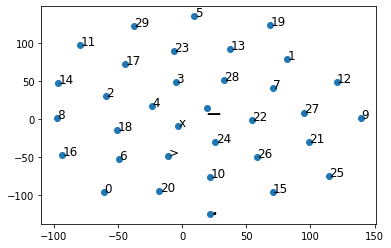

In [20]:
plt.scatter(embeddings_for_plot[:,0], embeddings_for_plot[:,1])
ax = plt.gca()
for tok, (x,y) in zip(tokens, embeddings_for_plot):
    fontsize = 12 if not tok in ['.', '_'] else 24
    ax.annotate(tok, (x+.3,y), fontsize=fontsize)
plt.show()

## Cosine Similarity
* Some embeddings have relatively simlar cosine similarities

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

In [22]:
cs_sim_mat = cosine_similarity(embeddings)
cs_sims = np.triu(cs_sim_mat, 1).ravel()
cs_sims = cs_sims[~np.isclose(cs_sims, 0)]

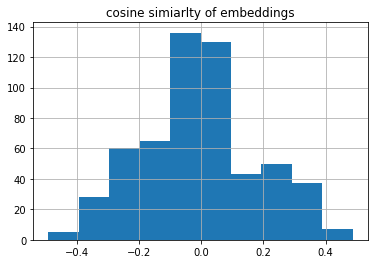

In [23]:
plt.title('cosine simiarlty of embeddings')
pd.Series(cs_sims).hist()
plt.show()

In [24]:
cs_sim_mat.shape

(34, 34)

In [25]:
tokens

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', 'x', '_', '.', '>'],
      dtype='<U11')

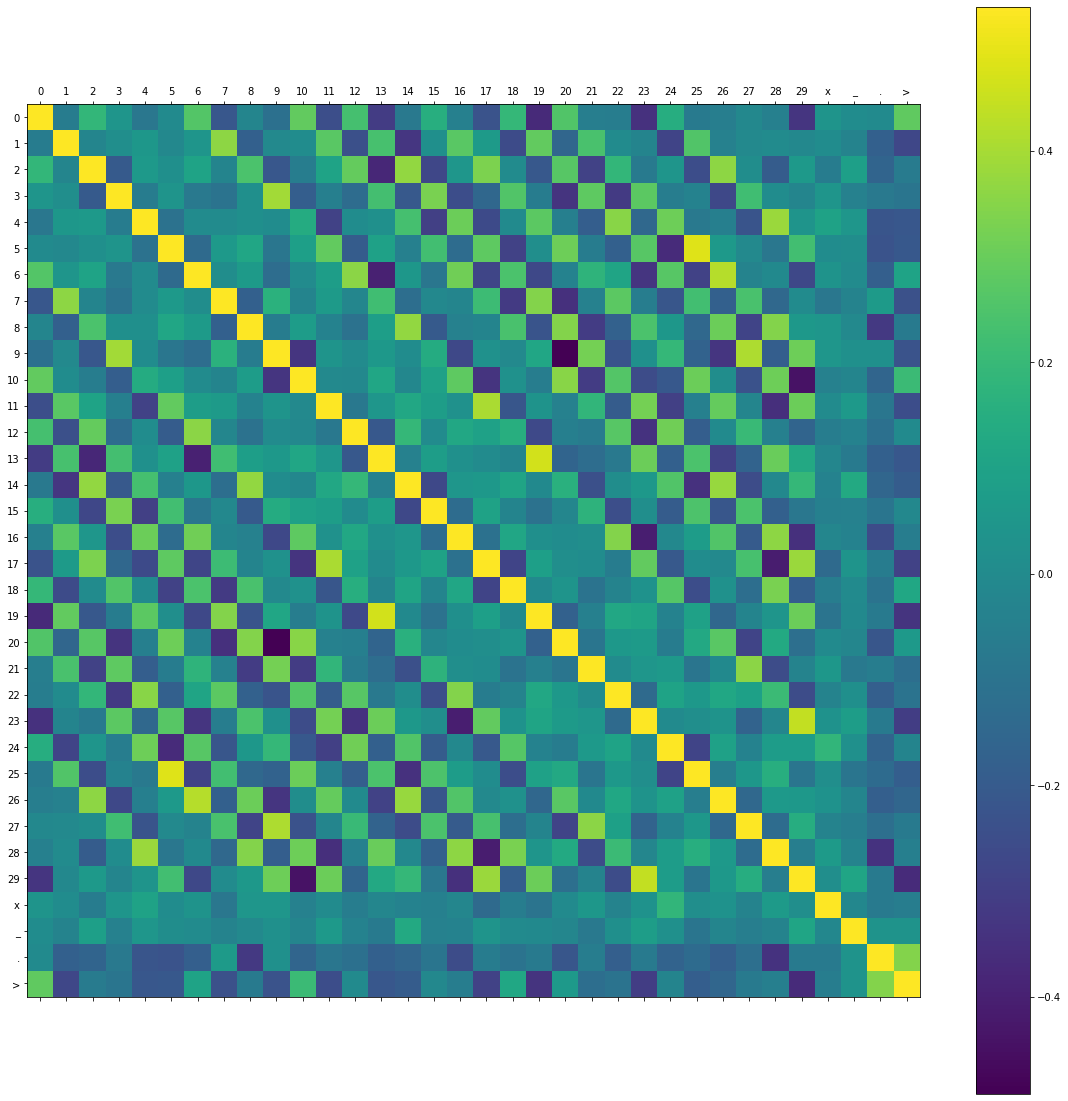

In [26]:
fig = plt.gcf()
fig.set_size_inches(20, 20)
ax = plt.gca()
plt.colorbar(ax.matshow(np.clip(cs_sim_mat, a_min=-1, a_max=cs_sim_mat[cs_sim_mat<.99].max()*1.1)), ax=ax)
ax.set_xticks(np.arange(cs_sim_mat.shape[0]))
ax.set_yticks(np.arange(cs_sim_mat.shape[0]))
ax.set_xticklabels(tokens[:cs_sim_mat.shape[0]])
ax.set_yticklabels(tokens[:cs_sim_mat.shape[0]])
plt.show()

### Are the embeddings linearly predictive of anything interesting?

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [28]:
logreg = LogisticRegression(C = .1, penalty='l1', solver='liblinear')
# logreg = SVC()

In [29]:
embeddings.shape, tokens.shape

((34, 256), (34,))

In [30]:
logreg_x = embeddings[:-4]
logreg_y = tokens[:-4].astype(int) % 2

In [31]:
train_indexer = np.random.rand(logreg_x.shape[0]) < .8
logreg_x_train = logreg_x[train_indexer]
logreg_x_test = logreg_x[~train_indexer]

logreg_y_train = logreg_y[train_indexer]
logreg_y_test = logreg_y[~train_indexer]

In [32]:
logreg_x_train.shape, logreg_y_train.shape

((25, 256), (25,))

In [33]:
logreg_x_test.shape, logreg_y_test.shape

((5, 256), (5,))

In [34]:
logreg.fit(logreg_x_train, logreg_y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [35]:
logreg.score(logreg_x_train, logreg_y_train)

0.6

In [36]:
logreg.score(logreg_x_test, logreg_y_test)

0.0

# How well does the model do on numbers higher than what it was trained on?

In [37]:
start = 2**16
length = 100
numbers = np.arange(start, start + length)

In [38]:
t

In [39]:
larger_df = problem.form_prediction_df(model, device, numbers, args['model_args']['max_decode_size'], n_beams = 10)

  0%|          | 0/100 [00:00<?, ?it/s]

In [40]:
larger_df.shape

(1000, 18)

In [41]:
larger_df.head(10)

,input_num,model_input,beam_idx,log_prob,pred_str,pred_factor_list,product,num_pred_factors,num_prime_factors_pred,percent_prime_factors_pred,correct_product,correct_factorization,pred_same_as_input,input_is_prime,target_factor_str,target_factor_list,num_target_factors,min_target_prime_factor_if_composite
0,65536,"[>, 2, 12, 24, 16, .]",0,-0.004587,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 . _ _ _ _ _ _ _ _,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",65536,16,16,1.000000,True,True,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2
1,65536,"[>, 2, 12, 24, 16, .]",1,-6.340979,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 19 . _ _ _ _ _ _ _ _ _ _,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 19]",311296,15,15,1.000000,False,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2
2,65536,"[>, 2, 12, 24, 16, .]",2,-7.541238,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 7 x 11 . _ _ _ _ _ _ _ _ _ _,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 11]",630784,15,15,1.000000,False,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2
3,65536,"[>, 2, 12, 24, 16, .]",3,-8.073759,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 8 23 . _ _ _ _ _ _ _ _ _ _ _,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 263]",2154496,14,14,1.000000,False,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2
4,65536,"[>, 2, 12, 24, 16, .]",4,-8.350014,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 11 . _ _ _ _ _ _ _ _,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 11]",360448,16,16,1.000000,False,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2
5,65536,"[>, 2, 12, 24, 16, .]",5,-8.399263,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 1 . _ _ _ _ _ _ _ _,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]",32768,16,15,0.937500,False,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2
6,65536,"[>, 2, 12, 24, 16, .]",6,-8.694835,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 1 1 . _ _ _ _ _,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 31]",2031616,17,17,1.000000,False,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2
7,65536,"[>, 2, 12, 24, 16, .]",7,-8.759013,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 1 . _ _ _ _ _ _,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]",65536,17,16,0.941176,True,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2
8,65536,"[>, 2, 12, 24, 16, .]",8,-8.932208,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 1 17 . _ _ _ _ _ _ _,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 47]",1540096,16,16,1.000000,False,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2
9,65536,"[>, 2, 12, 24, 16, .]",9,-9.214927,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 . _ _ _ _ _ _ _ 27,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 87]",2850816,16,15,0.937500,False,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2


In [42]:
larger_df.groupby('input_num').agg({'correct_factorization' : 'any'}).mean()

correct_factorization    0.97
dtype: float64

In [43]:
top_beams = larger_df['beam_idx'] == 8
(larger_df[top_beams]['product'] < larger_df[top_beams]['input_num']).mean()

0.22

### how does it handle squares/cubes/...?

In [44]:
from sympy import factorint
from sympy.ntheory import primerange

In [45]:
max_num = 256
squares = np.array(list(primerange(2, max_num)))**2
cubes = np.array(list(primerange(2, max_num)))**3

In [46]:
square_df = problem.form_prediction_df(model, device, squares, args['model_args']['max_decode_size'], n_beams = 10)

  0%|          | 0/54 [00:00<?, ?it/s]

In [47]:
square_df[square_df['beam_idx']==0]['correct_factorization'].mean()

0.1111111111111111

In [48]:
square_df.groupby('input_num').agg({'correct_factorization' : 'any'}).mean()

correct_factorization    0.592593
dtype: float64

In [52]:
square_df

,input_num,model_input,beam_idx,log_prob,pred_str,pred_factor_list,product,num_pred_factors,num_prime_factors_pred,percent_prime_factors_pred,correct_product,correct_factorization,pred_same_as_input,input_is_prime,target_factor_str,target_factor_list,num_target_factors,min_target_prime_factor_if_composite
0,4,"[>, 4, .]",0,-0.000281,> 2 x 2 . _ _ _,"[2, 2]",4,2,2,1.000000,True,True,False,False,> 2 x 2 .,"[2, 2]",2,2
1,4,"[>, 4, .]",1,-8.205848,> 2 x 2 x 1 1 .,"[2, 2, 31]",124,3,3,1.000000,False,False,False,False,> 2 x 2 .,"[2, 2]",2,2
2,4,"[>, 4, .]",2,-9.210621,> 2 x 2 . _ _ 27,"[2, 87]",174,2,1,0.500000,False,False,False,False,> 2 x 2 .,"[2, 2]",2,2
3,4,"[>, 4, .]",3,-9.210621,> 2 x 2 . _ _ 22,"[2, 82]",164,2,1,0.500000,False,False,False,False,> 2 x 2 .,"[2, 2]",2,2
4,4,"[>, 4, .]",4,-9.210621,> 2 x 2 . _ _ 9,"[2, 69]",138,2,1,0.500000,False,False,False,False,> 2 x 2 .,"[2, 2]",2,2
5,4,"[>, 4, .]",5,-9.210621,> 2 x 2 . _ _ 8,"[2, 68]",136,2,1,0.500000,False,False,False,False,> 2 x 2 .,"[2, 2]",2,2
6,4,"[>, 4, .]",6,-9.210621,> 2 x 2 . _ _ 23,"[2, 83]",166,2,2,1.000000,False,False,False,False,> 2 x 2 .,"[2, 2]",2,2
7,4,"[>, 4, .]",7,-9.210621,> 2 x 2 . _ _ .,"[2, 2]",4,2,2,1.000000,True,True,False,False,> 2 x 2 .,"[2, 2]",2,2
8,4,"[>, 4, .]",8,-9.210621,> 2 x 2 . _ _ 3,"[2, 63]",126,2,1,0.500000,False,False,False,False,> 2 x 2 .,"[2, 2]",2,2
9,4,"[>, 4, .]",9,-9.210621,> 2 x 2 . _ _ 2,"[2, 62]",124,2,1,0.500000,False,False,False,False,> 2 x 2 .,"[2, 2]",2,2


In [49]:
cube_df = problem.form_prediction_df(model, device, cubes, args['model_args']['max_decode_size'], n_beams = 10)

  0%|          | 0/54 [00:00<?, ?it/s]

In [50]:
cube_df[cube_df['beam_idx']==0]['correct_factorization'].mean()

0.09259259259259259

In [51]:
cube_df.groupby('input_num').agg({'correct_factorization' : 'any'}).mean()

correct_factorization    0.37037
dtype: float64

### When encoding two different numbers, what are the cosine similarities of their representations?

In [53]:
first_int = 16
second_int = 32

In [54]:
def get_reps_for_number(number):
    tokens = t.encode(problem.form_input(number, args['data']['base']))
    tens = torch.tensor(tokens).unsqueeze(0).to(device)
    memory, _ = model.encode(tens)
    return memory.squeeze().data.cpu().numpy(), tokens

In [55]:
first_reps, first_tokens = get_reps_for_number(first_int)
second_reps, second_tokens = get_reps_for_number(second_int)

In [56]:
cs_sims = cosine_similarity(first_reps, second_reps)

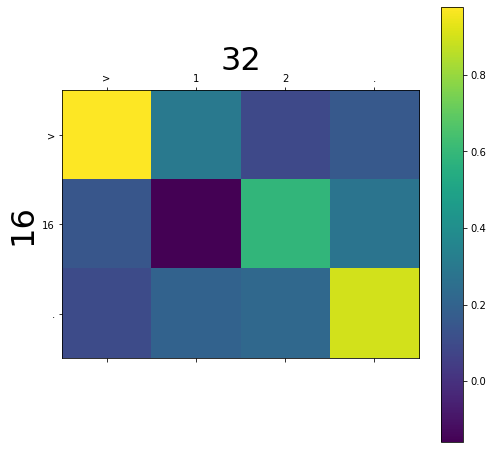

In [57]:
fig = plt.gcf()
fig.set_size_inches(8,8)
ax = plt.gca()
plt.colorbar(ax.matshow(cs_sims), ax=ax)
ax.set_xticks(np.arange(cs_sims.shape[1]))
ax.set_yticks(np.arange(cs_sims.shape[0]))
ax.set_xticklabels(t.decode(second_tokens, decode_special=True).split(' '))
ax.set_yticklabels(t.decode(first_tokens, decode_special=True).split(' '))

plt.xlabel(second_int, fontsize=32)
ax.xaxis.set_label_position('top') 
plt.ylabel(first_int, fontsize=32)

plt.show()

# When the model gets it wrong, what is the probability of the right sequence?

In [58]:
import Levenshtein

In [59]:
target_num = 277337

In [60]:
num_df = problem.form_prediction_df(model, device,  np.array([target_num]), args['model_args']['max_decode_size'], n_beams=10)
num_df['lev_dist'] = num_df.apply(lambda x: Levenshtein.distance(x['pred_str'].replace(' _', ''), x['target_factor_str']), axis=1)
num_df

  0%|          | 0/1 [00:00<?, ?it/s]

,input_num,model_input,beam_idx,log_prob,pred_str,pred_factor_list,product,num_pred_factors,num_prime_factors_pred,percent_prime_factors_pred,correct_product,correct_factorization,pred_same_as_input,input_is_prime,target_factor_str,target_factor_list,num_target_factors,min_target_prime_factor_if_composite,lev_dist
0,277337,"[>, 10, 8, 4, 17, .]",0,-1.165038,> 10 8 4 17 . _ _ _ _ _,[277337],277337,1,0,0.0,True,False,True,False,> 15 13 x 19 29 .,"[463, 599]",2,463,8
1,277337,"[>, 10, 8, 4, 17, .]",1,-1.835820,> 7 x 17 x 23 x 3 11 . _,"[7, 17, 23, 101]",276437,4,4,1.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,12
2,277337,"[>, 10, 8, 4, 17, .]",2,-2.655090,> 11 x 19 x 1 1 x 1 13 .,"[11, 19, 31, 43]",278597,4,4,1.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,12
3,277337,"[>, 10, 8, 4, 17, .]",3,-2.778504,> 1 29 x 5 6 13 . _ _ _,"[59, 4693]",276887,2,1,0.5,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,8
4,277337,"[>, 10, 8, 4, 17, .]",4,-3.186205,> 13 x 2 13 x 9 23 . _ _,"[13, 73, 293]",278057,3,3,1.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,7
5,277337,"[>, 10, 8, 4, 17, .]",5,-3.387727,> 17 x 7 x 23 x 3 11 . _,"[17, 7, 23, 101]",276437,4,4,1.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,12
6,277337,"[>, 10, 8, 4, 17, .]",6,-3.633612,> 2 7 x 4 16 11 . _ _ _,"[67, 4091]",274097,2,2,1.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,9
7,277337,"[>, 10, 8, 4, 17, .]",7,-3.653864,> 23 x 7 x 17 x 3 11 . _,"[23, 7, 17, 101]",276437,4,4,1.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,12
8,277337,"[>, 10, 8, 4, 17, .]",8,-3.968162,> 11 x 27 22 7 . _ _ _ _,"[11, 24967]",274637,2,2,1.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,8
9,277337,"[>, 10, 8, 4, 17, .]",9,-4.288523,> 19 x 11 20 23 . _ _ _ _,"[19, 10523]",199937,2,1,0.5,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,8


In [61]:
problem.form_label(target_num, args['data']['base'])

['>', 15, 13, 'x', 19, 29, '.']

In [62]:
def get_prob_of_factorization(number, factorization):
    tokens = t.encode(problem.form_input(number, args['data']['base']))
    tensor_input = torch.tensor(tokens).unsqueeze(0).to(device)
    
    factorization_input = torch.tensor(t.encode(factorization)).unsqueeze(0).to(device)
    
    model_output = torch.softmax(model(tensor_input, factorization_input).squeeze(0), dim=-1)
    
    probs = model_output[torch.arange(model_output.size(0)-1),factorization_input[0,1:]]
    
    return probs.log().sum()

In [63]:
get_prob_of_factorization(target_num, num_df.iloc[0]['target_factor_str'].strip().split(' '))

tensor(-4.8159, device='cuda:0', grad_fn=<SumBackward0>)

In [64]:
torch.tensor(t.encode(num_df.iloc[0]['target_factor_str'].strip().split(' '))).unsqueeze(0).to(device)

tensor([[33, 15, 13, 30, 19, 29, 32]], device='cuda:0')